# Setup

In [55]:
import os
import sys
import torch
import torchvision
import torchvision.transforms as transforms
import einops

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

if "x-perceiver" not in os.listdir(): 
    os.chdir("/Users/konsti/Documents/repos/phd/x-perceiver/")
    
%reload_ext autoreload
%autoreload 2

## Simple perceiver vision model

In [2]:
cifar_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=cifar_transform)
cifar_trainloader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

cifar_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=cifar_transform)
cifar_testloader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
cifar_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

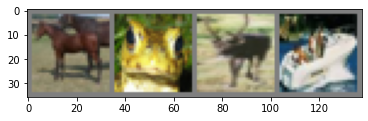

horse frog  deer  ship 


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(cifar_trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

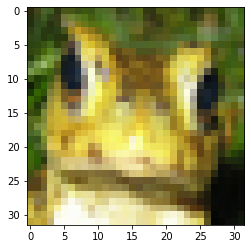

In [5]:
from einops import rearrange, reduce, repeat

img = images[1]
imshow(img)
# add axis
def preprocess_cifar(img, batch_size: int=None) -> torch.Tensor: 
    """
    Reshapes torch tensors from CIFAR format (c h w) to 
    required format for Perceiver: b h w c
    """
    if batch_size is None: 
        # introduce batch dim if not given
        img = repeat(img, 'c h w -> b c h w', b=1)
        # reorder 
    img_new = rearrange(img, 'b c h w -> b h w c')

    return img_new

img_new = preprocess_cifar(img)

In [6]:
from x_perceiver.perceiver import Perceiver

In [7]:
image_perceiver = Perceiver( 
    input_channels=3, 
    input_axis=2, 
    num_freq_bands=6, 
    depth=2, # number of cross-attention iterations 
    max_freq=10., 
)

In [ ]:
# Implement train loop 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from typing import *

# model = image_perceiver
# preprocess_fn = preprocess_cifar



def train_loop(
    preprocess_fn: Callable, 
    model: nn.Module, 
    trainloader: torch.utils.data.DataLoader,
    batch_size: int
) -> None: 
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(1):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
#             if i % 10 == 1: 
            print(f"Processing batch {i}...")
    #         get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            if preprocess_fn is not None: 
                inputs = preprocess_fn(inputs, batch_size=batch_size)

    #         # zero the parameter gradients
            optimizer.zero_grad()

    #         # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    #         # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')


# train_loop(preprocess_fn=preprocess_cifar, model=image_perceiver, trainloader=cifar_trainloader)

## Tabular perceiver model

In [118]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [119]:
from torch.utils.data import Dataset

In [120]:
class SklearnDataset(Dataset): 
    """
    Simple wrapper to load sklearn dataset as PyTorch dataset object
    """
    def __init__(self, load_fn): 
        # load in data
        self.df = load_fn()
        
    def __len__(self):
        return self.df["data"].shape[0]
    
    def __getitem__(self, idx):
        item = torch.Tensor(self.df["data"][idx])
        # add batch dim to tensor
        item = einops.repeat(item, 'feats -> b feats c', b=1, c=1)
        label = self.df["target"][idx]
        return item, label
        
        

In [121]:
wbc = SklearnDataset(load_breast_cancer)

In [122]:
batch_size = 200

wbc_trainloader = torch.utils.data.DataLoader(wbc, 
                                              batch_size=batch_size,
                                              shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [123]:
wbc_iter = iter(wbc_trainloader)
sample, label = next(wbc_iter)

In [124]:
tabular_perceiver = Perceiver( 
    input_channels=1, 
    input_axis=2, # second axis (b n_feats c)
    num_freq_bands=6, 
    depth=2, 
    max_freq=10., 
)

In [125]:
train_loop(preprocess_fn=None, model=tabular_perceiver, trainloader=wbc_trainloader, batch_size=batch_size)

KeyboardInterrupt: 